# Automatic Ticket Classification - NLP with NMF and ML Models

## 1. Problem Statement

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We need to do topic modelling on the <b>json</b> data provided by the finance company. Since this data is not labelled, we need to apply **Non-Negative Matrix Factorization (NMF)** to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of **Topic Modelling**, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as **logistic regression, decision tree or random forest**. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

### 1.1 Our Approach:

We will perform the following eight major tasks to complete the assignment:

1. Data Loading

2. Text Preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic Modelling

6. Model Building using Supervised Learning

7. Best Model Selection

8. Model Inference

9. Conclusion

## 2. Data Loading

The data is in JSON format and we need to convert it to a dataframe.

### 2.1 Import Necessary Libraries

In [1]:
# Import basic python libraries
import json
import numpy as np
import pandas as pd

# Import NLP specific libraries
import re, nltk, spacy, string
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# Import misc libraries
from pprint import pprint

# Import library to hide warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2 Load Data from Drive

In [2]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Write the path to data file
data_path = '/content/drive/MyDrive/DS Datasets/complaints-2021-05-14_08_16.json'

In [4]:
# Open JSON file
f = open(data_path)

# Read JSON object as a dictionary
data = json.load(f)
data[:1]

[{'_index': 'complaint-public-v2',
  '_type': 'complaint',
  '_id': '3211475',
  '_score': 0.0,
  '_source': {'tags': None,
   'zip_code': '90301',
   'complaint_id': '3211475',
   'issue': 'Attempts to collect debt not owed',
   'date_received': '2019-04-13T12:00:00-05:00',
   'state': 'CA',
   'consumer_disputed': 'N/A',
   'product': 'Debt collection',
   'company_response': 'Closed with explanation',
   'company': 'JPMORGAN CHASE & CO.',
   'submitted_via': 'Web',
   'date_sent_to_company': '2019-04-13T12:00:00-05:00',
   'company_public_response': None,
   'sub_product': 'Credit card debt',
   'timely': 'Yes',
   'complaint_what_happened': '',
   'sub_issue': 'Debt is not yours',
   'consumer_consent_provided': 'Consent not provided'}}]

In [5]:
# Store the data into a dataframe
complaints_df = pd.json_normalize(data)

### 2.3 Inspect & Understand Data

In [6]:
# Inspect the dataframe to understand the given data.

complaints_df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00            CA  ...  Closed with explanation   
1  2019-05-01T12:00:00-05:00            GA  ...  Closed with explanation   
2  2019-04-02T12:00:00-05:00            TX  ...  Closed with explanation   
3  2017-09-13T12:00:00-05:00            MI  ...  Closed with explanation   
4  2019-04-05T12:00:00-05:00            NY  ...  Closed with explanation   

        _source.company _source.submitted_via _source.date_sent_to_company  \
0  JPMORGAN CHASE & CO.                   Web    2019-04-13T12:00:00-05:00   
1  JPMORGAN CHASE & CO.                   Web    2019-05-01T12:00:00-05:00   
2  JPMORGAN CHASE & CO.                   Web    2019-04-02T12:00:00-05:00   
3  JPMORGAN CHASE & CO.                   Web    2017-09-14T12:00:00-05:00   
4  JPMORGAN CHASE & CO.              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely                    _source.complaint_what_happened  \
0            Yes                                                      
1            Yes  Good morning my name is XXXX XXXX and I apprec...   
2            Yes  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
3            Yes                                                      
4            Yes                                                      

                                  _source.sub_issue  \
0                                 Debt is not yours   
1  Didn't receive enough information to verify debt   
2             Problem with rewards from credit card   
3                                              None   
4                         Charged too much interest   

  _source.consumer_consent_provided  
0              Consent not provided  
1                  Consent provided  
2                  Consent provided  
3              Consent not provided  
4                               N/A  

[5 rows x 22 columns]

In [7]:
# Check the shape of the dataframe
complaints_df.shape

(78313, 22)

In [8]:
# Print the column names
complaints_df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
# Retain the columns necessary for further analysis
complaints_df = complaints_df[['_source.complaint_what_happened','_source.product','_source.sub_product']]

# Assign more meaningful column names
complaints_df = complaints_df.rename(columns={'_source.complaint_what_happened': 'complaint_details', '_source.product': 'product','_source.sub_product': 'sub_product'})
complaints_df.head()

complaint_details  \
0                                                      
1  Good morning my name is XXXX XXXX and I apprec...   
2  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
3                                                      
4                                                      

                       product                                 sub_product  
0              Debt collection                            Credit card debt  
1              Debt collection                            Credit card debt  
2  Credit card or prepaid card  General-purpose credit card or charge card  
3                     Mortgage                  Conventional home mortgage  
4  Credit card or prepaid card  General-purpose credit card or charge card

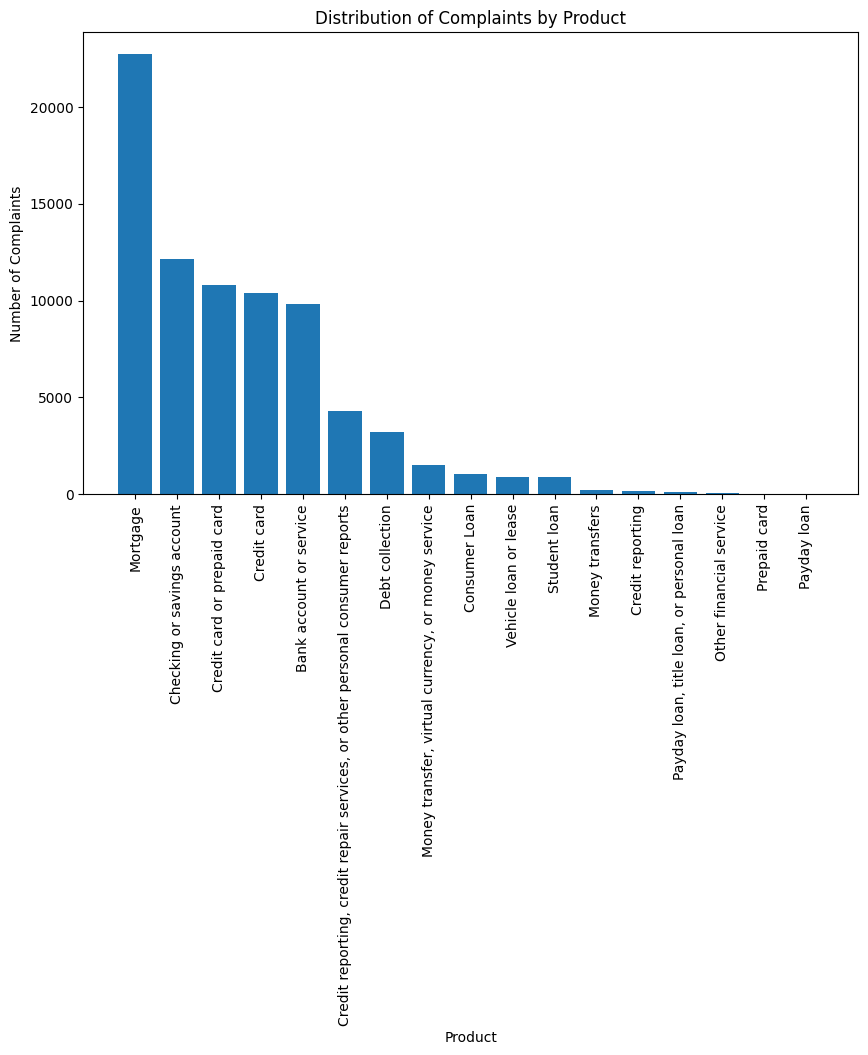

In [10]:
# Check Distribution of Complaints by Product

product_counts = complaints_df['product'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(product_counts.index, product_counts.values)
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.title("Distribution of Complaints by Product")
_ = plt.xticks(rotation=90)

## 3. Text Preprocessing

### 3.1 Handle Missing Data

In [11]:
# Assign nan in place of blanks in the complaints column
complaints_df[complaints_df['complaint_details']==''] = np.nan
complaints_df.complaint_details.isnull().sum()

57241

In [12]:
# Remove all rows where complaints column is nan
complaints_df = complaints_df[~complaints_df['complaint_details'].isnull()]
complaints_df.complaint_details.isnull().sum()

0

### 3.2 Prepare Data for Topic Modeling

Once all the blank complaints are removed, we need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once we have done these cleaning operations we need to perform the following:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than Noun[tag == "NN"].


In [13]:
# Define function to clean the text and remove all the unnecessary elements.
def transform_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub('\[.*\]','', text).strip() # Substitute text in square brackets with blanks
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [14]:
# Instantiate nlp model for relevant text processing
nlp = en_core_web_sm.load()

In [15]:
# Define function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatize_text(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [16]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = complaints_df[['complaint_details']].copy()
df_clean['complaint_lemmatized'] = complaints_df['complaint_details'].apply(lambda x: transform_text(x)) # Clean the complain_details text
df_clean['complaint_lemmatized'] = df_clean['complaint_details'].apply(lambda x: lemmatize_text(x)) # Lemmatize the cleaned text

In [17]:
# Inspect the transformed dataframe

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  
1   good morning XXXX XXXX I appreciate help stop ...  
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...  
10  Chase Card report XX / XX/2019 . however , fra...  
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...  
14  grand son check { $ 1600.00 } deposit chase ac...

In [18]:
# Define a function to extract the 'NN' POS tags

def extract_nn_pos_tag(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)


# Create a column that would contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["complaint_lemmatized"].apply(lambda x: extract_nn_pos_tag(x))

In [19]:
# Inspect the clean dataframe which now contains the raw complaint, lemmatized complaint and the complaint after removing POS tags
df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  \
1   good morning XXXX XXXX I appreciate help stop ...   
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...   
10  Chase Card report XX / XX/2019 . however , fra...   
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...   
14  grand son check { $ 1600.00 } deposit chase ac...   

                                complaint_POS_removed  
1   morning XXXX XXXX help cardmember service debt...  
2   card agent anniversary date change agent infor...  
10  report application submit identity consent ser...  
11  book xxxx ticket ticket reward card informatio...  
14  son deposit chase account fund bank account pa...

In [20]:
# Check the shape of the pre-processed dataframe
df_clean.shape

(21072, 3)

## 4. Exploratory Data Analysis (EDA)

We will perform the following in this section:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text




### 4.1 Visualise 'Complaints' Distribution by Length

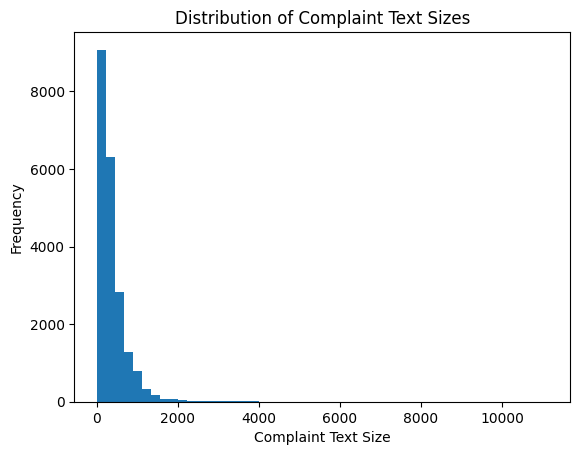

In [21]:
# Visualise the data according to the 'Complaint' character length
comp_size = [len(comp) for comp in df_clean.complaint_POS_removed]

# Plot a histogram for complaints text sizes
plt.hist(comp_size, bins = 50)
plt.xlabel('Complaint Text Size')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Text Sizes')
plt.show()

**Observation:** Most complaints have lengths that fall in first 3 bins i.e. less than 600 characters. There are a few complaints which are larger than 2000 characters.

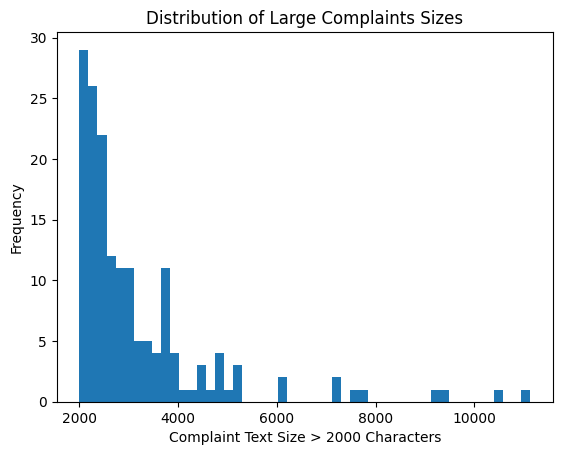

In [22]:
# Plot a separate histogram for complaint sizes having higher than 2000 characters as those are not visible in above histogram
comp_size = [len(comp) for comp in df_clean.complaint_POS_removed if len(comp) > 2000]

# Plot a histogram for complaints text sizes
plt.hist(comp_size, bins = 50)
plt.xlabel('Complaint Text Size > 2000 Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Large Complaints Sizes')
plt.show()

**Observations:** There are about 100 complaints which are of large size

### 4.2 Visualise the Top 40 Words by Frequency

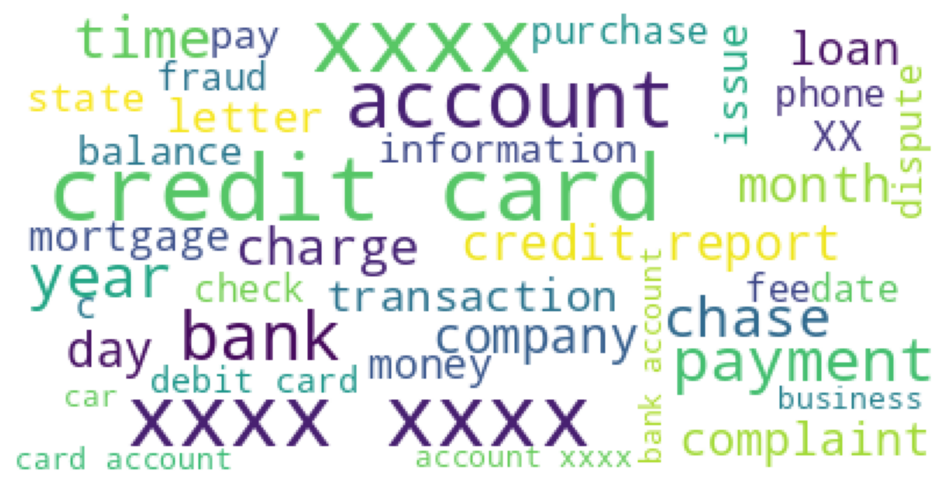

In [23]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordcloud = WordCloud( background_color='white', stopwords=stopwords, max_words=40, max_font_size=40, random_state=42 ).generate(str(df_clean['complaint_POS_removed']))

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Observations:** Top words are Account, Credit, Card, Bank, Payment, Mortgage etc. which are related to core areas of a Bank's operation. Hence a Topic Modelling using text analysis will yield effective outcome for complaint classification. There are many XXXX masked words that can be removed before modelling to avoid data skewing.

In [24]:
# Remove -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

### 4.3 Determine top N-Grams by Frequency

Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
# Define a generic function that can return top m frequent n-gram complaints in the cleaned dataframe

def get_top_ngrams(corpus, ngram=1, m=None):
    vec = CountVectorizer(ngram_range=(ngram,ngram), stop_words = list(stopwords)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:m]

In [26]:
# Find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean)
top_30_unigrams = get_top_ngrams(df_clean.complaint_clean, ngram=1, m=30)

In [27]:
# Print the top 10 words in the unigram frequency
print('Top 10 Unigrams:\n')
top_30_unigrams[:10]

Top 10 Unigrams:



[('xxxx', 61284),
 ('account', 42994),
 ('credit', 30946),
 ('card', 27049),
 ('payment', 20704),
 ('time', 15962),
 ('bank', 15697),
 ('charge', 14359),
 ('day', 13119),
 ('money', 11838)]

In [28]:
# Find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean)
top_30_bigrams = get_top_ngrams(df_clean.complaint_clean, ngram=2, m=30)

In [29]:
# Print the top 10 words in the bigram frequency
print('Top 10 Bigrams:\n')
top_30_bigrams[:10]

Top 10 Bigrams:



[('xxxx xxxx', 13236),
 ('credit card', 11349),
 ('credit report', 3752),
 ('customer service', 2584),
 ('account account', 2277),
 ('account xxxx', 1975),
 ('bank account', 1845),
 ('debit card', 1794),
 ('xxxx credit', 1698),
 ('credit score', 1645)]

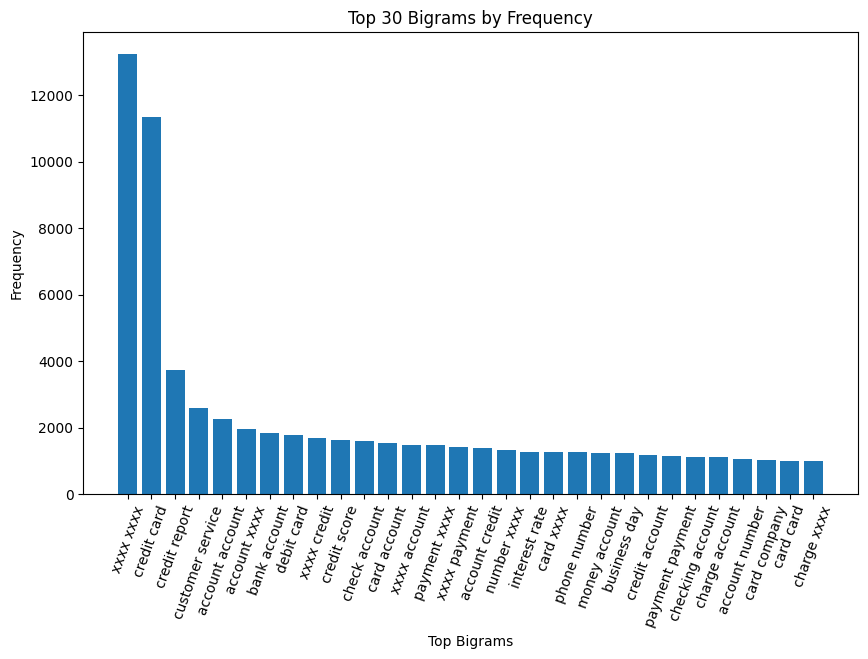

In [30]:
# Plot the top 30 Bigrams by frequency
bigrams = [bigram[0] for bigram in top_30_bigrams]
freq = [bigram[1] for bigram in top_30_bigrams]

plt.figure(figsize=(10, 6))
plt.bar(bigrams, freq)
plt.xlabel("Top Bigrams")
plt.ylabel("Frequency")
plt.xticks(rotation = 70)
plt.title("Top 30 Bigrams by Frequency")

plt.show()

In [31]:
# Find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean)
top_30_trigrams = get_top_ngrams(df_clean.complaint_clean, ngram=3, m=30)

In [32]:
# Print the top 10 words in the trigram frequency
print('Top 10 Trigrams:\n')
top_30_trigrams[:10]

Top 10 Trigrams:



[('xxxx xxxx xxxx', 3718),
 ('credit card account', 1046),
 ('credit card company', 890),
 ('xxxx credit card', 806),
 ('credit card xxxx', 497),
 ('credit card credit', 488),
 ('inquiry credit report', 472),
 ('charge credit card', 440),
 ('account credit card', 432),
 ('card credit card', 401)]

**Observations:** The top-30 Unigrams show similar occurrences as seen in Wordcloud. The Bigrams reveal frequently used terms in financial world well which are present in the complaints.

**The personal details of customer has been masked in the dataset with xxxx.** Let's remove the masked text as this will be of no use for our analysis

In [33]:
# Remove both XXXX and xxxx from complaint_clean column
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('XXXX', '').str.replace('xxxx', '')


In [34]:
# All masked texts has been removed
df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  \
1   good morning XXXX XXXX I appreciate help stop ...   
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...   
10  Chase Card report XX / XX/2019 . however , fra...   
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...   
14  grand son check { $ 1600.00 } deposit chase ac...   

                                      complaint_clean  
1   morning   help cardmember service debt verific...  
2   card agent anniversary date change agent infor...  
10  report application submit identity consent ser...  
11  book  ticket ticket reward card information mi...  
14  son deposit chase account fund bank account pa...

In [35]:
# Export df_clean to a csv on Google Drive so that this can be imported and used for later part of solution
df_clean.to_csv('/content/drive/MyDrive/DS Datasets/clean_complaints.csv', index=False)

In [36]:
# Uncomment and run the below code to avoid preprocessing steps already done on the dataset
# in order to accelerate remaining part of the solutioning
# df_clean = pd.read_csv('/content/drive/MyDrive/DS Datasets/clean_complaints.csv')
# df_clean.head()

In [37]:
# df_clean.shape

## 5. Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
# Initialise the TfidfVectorizer with max_df as 95% and min_df as 2
complaints_tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


**Create a document term matrix using fit_transform**

The contents of a document term matrix are tuples of (complaint_id,token_id) each having a tf-idf score. The tuples that are not there have a tf-idf score of 0.

In [39]:
# Remove any rows in the dataframe which have null values in complaint_clean column
# For some very short complaints, their length may become zero after text processing steps

print("Null Rows count before nan removal: ", df_clean['complaint_clean'].isnull().sum())

df_clean = df_clean[~df_clean['complaint_clean'].isnull()]

Null Rows count before nan removal:  0


In [40]:
# Create the Document Term Matrix by transforming the complaints column present in df_clean
dtm = complaints_tfidf.fit_transform(df_clean['complaint_clean']) # Returns sparse matrix of (Doc ID, Token ID) tuples with respective TF-IDF scores

In [41]:
# Review the top 5 rows in Document Term Matrix
dtm_df = pd.DataFrame(dtm.toarray(), columns=complaints_tfidf.get_feature_names_out()) # Convert dtm to dense matrix and store in dataframe
dtm_df.head()

00  0111   0n  10day  13th   14   15   16   17   18   19   1a  1hr  1st  \
0  0.0   0.0  0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0   0.0  0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0   0.0  0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0   0.0  0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0   0.0  0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    20  2008  2012  2013  2014  2017  2018  2019  2020  2021   21   24  24hrs  \
0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   
1  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   
2  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   
3  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   
4  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   

    2d  2nd  2yr  30min  30yr   3d  3rd  45min  48hr  48hrs  5th  60day  6th  \
0  0.0  0.0  0.0    0.0   0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  0.0   
1  0.0  0.0  0.0    0.0   0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  0.0   
2  0.0  0.0  0.0    0.0   0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  0.0   
3  0.0  0.0  0.0    0.0   0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  0.0   
4  0.0  0.0  0.0    0.0   0.0  0.0  0.0    0.0   0.0    0.0  0.0    0.0  0.0   

   7th  8th   90  90day  aaa  abandon  abandonment  abate  abatement  abet  \
0  0.0  0.0  0.0    0.0  0.0      0.0          0.0    0.0        0.0   0.0   
1  0.0  0.0  0.0    0.0  0.0      0.0          0.0    0.0        0.0   0.0   
2  0.0  0.0  0.0    0.0  0.0      0.0          0.0    0.0        0.0   0.0   
3  0.0  0.0  0.0    0.0  0.0      0.0          0.0    0.0        0.0   0.0   
4  0.0  0.0  0.0    0.0  0.0      0.0          0.0    0.0        0.0   0.0   

   abhorrent  abide  ability  abovementione  absence  absolve  absorb  \
0        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
1        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
2        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
3        0.0    0.0      0.0            0.0      0.0      0.0     0.0   
4        0.0    0.0      0.0            0.0      0.0      0.0     0.0   

   absurdity  abundance  abuse  abuser  abusive   ac  acc  acccount  \
0        0.0        0.0    0.0     0.0      0.0  0.0  0.0       0.0   
1        0.0        0.0    0.0     0.0      0.0  0.0  0.0       0.0   
2        0.0        0.0    0.0     0.0      0.0  0.0  0.0       0.0   
3        0.0        0.0    0.0     0.0      0.0  0.0  0.0       0.0   
4        0.0        0.0    0.0     0.0      0.0  0.0  0.0       0.0   

   accelerate  acceleration  accent  accept  acceptance  access  \
0         0.0           0.0     0.0     0.0         0.0     0.0   
1         0.0           0.0     0.0     0.0         0.0     0.0   
2         0.0           0.0     0.0     0.0         0.0     0.0   
3         0.0           0.0     0.0     0.0         0.0     0.0   
4         0.0           0.0     0.0     0.0         0.0     0.0   

   accessibility  accessory  accident  accommodate  accommodation  \
0            0.0        0.0       0.0          0.0            0.0   
1            0.0        0.0       0.0          0.0            0.0   
2            0.0        0.0       0.0          0.0            0.0   
3            0.0        0.0       0.0          0.0            0.0   
4            0.0        0.0       0.0          0.0            0.0   

   accomodation  accompany  accomplice  accomplish  accont  accord  \
0           0.0        0.0         0.0         0.0     0.0     0.0   
1           0.0        0.0         0.0         0.0     0.0     0.0   
2           0.0        0.0         0.0         0.0     0.0     0.0   
3           0.0        0.0         0.0         0.0     0.0     0.0   
4           0.0        0.0         0.0         0.0     0.0

In [42]:
# Check the shape of the Document Term Matrix. The column length represent the total features
dtm_df.shape

(21072, 6150)

In [43]:
# Delete the dtm_df to free memory space, as it's not required for further processing
del dtm_df

## 6. Topic Modelling Using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no manual labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we need to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correlation of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

### 6.1 Perform Topic Modeling with 5 Clusters

Typically we need to do the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In this case we will go ahead with **5 clusters** which is reasonable keeping in mind the number of Products the Bank has.

In [45]:
# Load nmf_model with the n_components i.e. 5
num_topics = 5 # Number of topics we want to test out

# Instantiate NMF model keeping the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W = nmf_model.fit_transform(dtm) # Document-Topic Matrix
H = nmf_model.components_ # Feature-Topic Matrix

In [46]:
# Review the shaoes of W and H matrices
print("W-Shape:", W.shape)
print("H-Shape:", H.shape)

W-Shape: (21072, 5)
H-Shape: (5, 6150)


In [47]:
# Print the Top15 words for each of the topics
num_words=15

for i,topic in enumerate(H):
    print(f'Top 15 words for Topic #{i}:')
    print([complaints_tfidf.get_feature_names_out()[index] for index in topic.argsort()[-num_words:]])

Top 15 words for Topic #0:
['claim', 'customer', 'chase', 'transaction', 'business', 'transfer', 'number', 'branch', 'day', 'fund', 'deposit', 'money', 'bank', 'check', 'account']
Top 15 words for Topic #1:
['reason', 'time', 'offer', 'application', 'month', 'point', 'purchase', 'chase', 'limit', 'year', 'score', 'account', 'balance', 'credit', 'card']
Top 15 words for Topic #2:
['day', 'date', 'property', 'statement', 'rate', 'home', 'balance', 'pay', 'modification', 'year', 'time', 'month', 'mortgage', 'loan', 'payment']
Top 15 words for Topic #3:
['theft', 'date', 'reporting', 'file', 'identity', 'letter', 'score', 'remove', 'account', 'debt', 'company', 'information', 'inquiry', 'credit', 'report']
Top 15 words for Topic #4:
['email', 'day', 'statement', 'time', 'purchase', 'service', 'company', 'fraud', 'claim', 'refund', 'merchant', 'transaction', 'fee', 'dispute', 'charge']


In [48]:
# Determine the best topic for each complaint in terms of integer value 0,1,2,3 & 4

best_topics = W.argmax(axis=1)

In [49]:
# Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topics

In [50]:
# Review the top 5 rows in df_clean to confirm topic assignment
df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  \
1   good morning XXXX XXXX I appreciate help stop ...   
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...   
10  Chase Card report XX / XX/2019 . however , fra...   
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...   
14  grand son check { $ 1600.00 } deposit chase ac...   

                                      complaint_clean  Topic  
1   morning   help cardmember service debt verific...      0  
2   card agent anniversary date change agent infor...      1  
10  report application submit identity consent ser...      3  
11  book  ticket ticket reward card information mi...      3  
14  son deposit chase account fund bank account pa...      0

### 6.2 Map the Clusters to Topic Names

In [51]:
# Print the first 5 Complaint for each of the Topics
pd.set_option('display.max_colwidth', None)

df_clean.sort_values('Topic').groupby('Topic').head(5)

complaint_details  \
131                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             XX/XX/2019 {$200.00} for joining chase bank checking and setting up direct deposit. I set up direct deposit. Got my first deposit XX/XX/XXXX. 10 days later I received nothing. I called the bank and they said I needed a coupon code ( I didn't need one because I applied through the link that automatically applies it. ) I showed them the code and than they said I was not eligible because it wasnt soon enough. It cant be over 90 days well I set up mine within 30 days.   
133                                                                

In [52]:
# Reset the column width to the default
pd.reset_option('display.max_colwidth')

**Observations:** After evaluating the complaints w.r.t. the mapping, the following mapping can be done to clusters with topic names:

* 0 - Bank Account services
* 1 - Credit card or prepaid card
* 2 - Mortgage/Loan
* 3 - Others
* 4 - Theft/Dispute Reporting

In [53]:
# Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Others',
    4: 'Theft/Dispute Reporting'
   }
# Replace cluster numbers with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [54]:
# Check the correct assignment of Topic names to documents
df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  \
1   good morning XXXX XXXX I appreciate help stop ...   
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...   
10  Chase Card report XX / XX/2019 . however , fra...   
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...   
14  grand son check { $ 1600.00 } deposit chase ac...   

                                      complaint_clean  \
1   morning   help cardmember service debt verific...   
2   card agent anniversary date change agent infor...   
10  report application submit identity consent ser...   
11  book  ticket ticket reward card information mi...   
14  son deposit chase account fund bank account pa...   

                          Topic  
1         Bank Account services  
2   Credit card or prepaid card  
10                       Others  
11                       Others  
14        Bank Account services

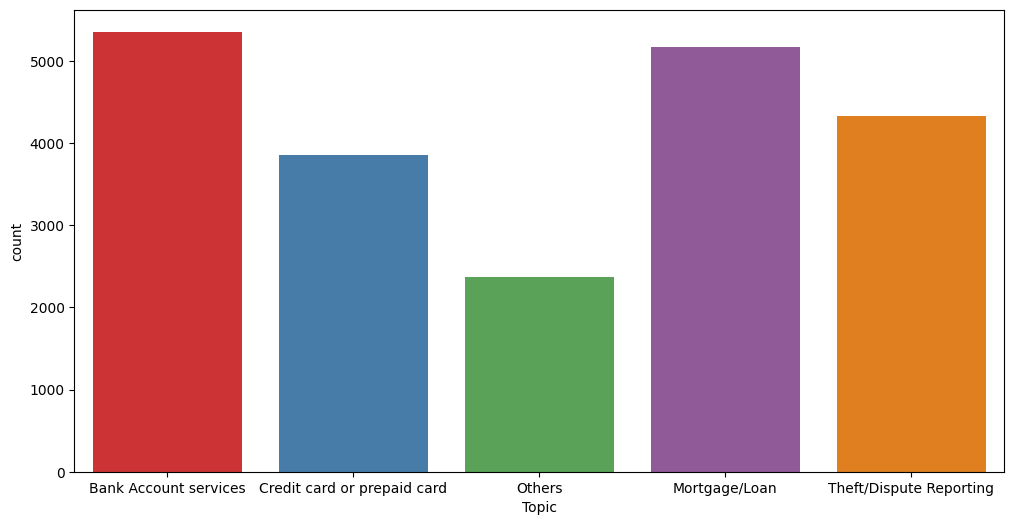

In [55]:
# Visualise complaints distribution by Topic Names to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df_clean, palette='Set1')
plt.show()

**Observations:** The graph shows that the data is quite balanced w.r.t. topic names

## 7. Model Building using Supervised Learning

We will now build various ML models to predict the topics for each complaint.Subsequently we will use them to classify any new complaint.

Since we will be using supervised learning technique we have to convert the topic names to numbers again (numpy arrays only understand numbers)

### 7.1 Create Training Data

In [56]:
# Create the dictionary again of Topic names and Topic numbers

Topic_numbers = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Mortgage/Loan':2,
    'Others':3,
    'Theft/Dispute Reporting':4
   }
# Replace Topic names with Topic Number
df_clean['Topic'] = df_clean['Topic'].map(Topic_numbers)

In [57]:
# Review the conversion of topic names to numbers
df_clean.head()

complaint_details  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                                 complaint_lemmatized  \
1   good morning XXXX XXXX I appreciate help stop ...   
2   I upgrade xxxx xxxx card XX / xx/2018 tell age...   
10  Chase Card report XX / XX/2019 . however , fra...   
11  on XX / XX/2018 , try book XXXX   xxxx   ticke...   
14  grand son check { $ 1600.00 } deposit chase ac...   

                                      complaint_clean  Topic  
1   morning   help cardmember service debt verific...      0  
2   card agent anniversary date change agent infor...      1  
10  report application submit identity consent ser...      3  
11  book  ticket ticket reward card information mi...      3  
14  son deposit chase account fund bank account pa...      0

In [58]:
# Export df_clean to a csv on Google Drive so that this can be imported and used for subsequent modelling exercise
df_clean.to_csv('/content/drive/MyDrive/DS Datasets/clean_complaints.csv', index=False)

In [59]:
# Uncomment the below code if we need to re-create df_clean from stored data
# df_clean = pd.read_csv('/content/drive/MyDrive/DS Datasets/clean_complaints.csv')
# df_clean.head()

In [60]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe i.e. training_data
training_data = df_clean[['complaint_details','Topic']]

In [61]:
training_data

complaint_details  Topic
1      Good morning my name is XXXX XXXX and I apprec...      0
2      I upgraded my XXXX XXXX card in XX/XX/2018 and...      1
10     Chase Card was reported on XX/XX/2019. However...      3
11     On XX/XX/2018, while trying to book a XXXX  XX...      3
14     my grand son give me check for {$1600.00} i de...      0
15                         Can you please remove inquiry      3
17     With out notice J.P. Morgan Chase restricted m...      0
20     During the summer months, I experience a decli...      2
21     On XXXX XX/XX/2019, I made a {$300.00} payment...      4
23     I have a Chase credit card which is incorrectl...      3
24     mishandling of this account by Chase auto and ...      0
26     I have reached out to XXXX several times in at...      3
27     I opened an account with chase bank on XXXX an...      0
30     To whom it may concern, Chase bank charged wro...      4
32     My chase amazon card was declined for a cateri...      1
35     I opened the saving account for the {$25.00} b...      0
40     XXXX XXXX a sofa, love seat, table and chairs ...      4
42     My card went missing and i didnt realize it un...      0
43     Chase sent me an email today with the innocuou...      0
45     I made a purchase with XXXX XXXX XXXX on XX/XX...      4
48     JP Morgan Chase Bank, please answer the follow...      3
50     I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...      1
52     My roommate was stealing my Chase debit card a...      1
57     I have been trying to do a loan modification w...      2
58     I made a purchase of {$260.00} on XX/XX/XXXX. ...      2
59     I currently have over XXXX Chase Ultimate Rewa...      1
63     I tried to send almost {$2000.00} at XXXX and ...      1
64     Chase is marketing credit cards to those of us...      1
65     I opened the Chase/XXXX XXXX Rewards credit ca...      1
69     Someone called stating I had felony committed ...      0
73     I have wired through one of Chase branches in ...      2
78     My Dispute is for not receiving services liste...      4
81     I bought a new XXXX XXXX on XX/XX/XXXX from XX...      2
82     I recently called to ask Chase bank why they r...      2
83     UNKNOWN INQUIRE REPORTED ON MY CREDIT BUREAU S...      3
86     A student loan with Chase bank, they sold ther...      3
88     I pre-ordered an item on XX/XX/XXXX and paid {...      4
92     In XX/XX/2019, several transactions on my Chas...      0
93     On XX/XX/2019 we purchased a service with XXXX...      4
94     I am writing you to file a complaint about an ...      1
95     On XX/XX/2019, I paid off my Chase credit card...      1
99     My name is XXXX XXXX. I have missed a payment ...      2
100    I have contacted both Chase Bank and XXXX XXXX...      3
101    I Purchase is an airline ticket on XX/XX/XXXX ...      4
103    On XX/XX/XXXX I received an advertisement via ...      0
111    I advised Chase of the billing error for goods...      0
115    Multiple times with the latest being XX/XX/XXX...      0
127    I am XXXX military member ( XXXX ) with the XX...      2
128    I have contacted JP Morgan Chase as well as XX...      1
129    This complaint is a follow up regarding a comp...      4
130    I purchased tickets ( using my XXXX XXXX XXXX ...      4
131    XX/XX/2019 {$200.00} for joining chase bank ch...      0
133    On XX/XX/2019 I made a deposit into my chase b...      0
134    In XX/XX/2017 I was no longer able to access m...      1
135    I checked my credit reports and noticed the in...      3
138    On XX/XX/2019, I submitted a complaint to my b...      4
139    Chase I'm filing a complaint After disputing w...      3
141    Action Taken By The Company Between the dates ...      2
142    ChaseMortgagehasautomaticallydeducted2mortgage...      0
143    Hello - I applied for a credit account with Am...      3
148    I have owned a Chase Ink Business Plus credit ...      1
149    I received a coupon which said " open or upgra...      0
150    

###7.2 Transform Training Data to Frequency Vector

We will do the following to transform complaints data to word vector
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf scores
* Split the tf-idf & topics data for complaints into train & test data


In [62]:
# Perform x - y  split
X = training_data.complaint_details
y = training_data.Topic

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer

# Get the count Vectoriser
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [64]:
# Split the training data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

We will explore the below 4 models on the train & test data with hyperparameter finetuning:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes

**Using the required evaluation metrics we would later select the one performing the best**

### 7.3 Create Utility Methods for Modelling

In [65]:
# Import required libraries

# Import the target model libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import GridSearch & Cross Validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Import model evaluation metrics libraries
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [66]:
# Define utility function to compute and store training & validation metrics - ROC, accuracy, precision, recall, classification report
def compute_model_metrics(model, metric):

    # Compute & store ROC scores
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    metric.append(round(roc_auc_score(y_train, y_train_pred_proba, average='weighted', multi_class='ovr'), 2))
    metric.append(round(roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr'), 2))

    # Compute & store accuracy, precision, recall
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metric.append(round(accuracy_score(y_train,y_train_pred), 2))
    metric.append(round(accuracy_score(y_test,y_test_pred), 2))
    metric.append(round(precision_score(y_train,y_train_pred,average='weighted'), 2))
    metric.append(round(precision_score(y_test,y_test_pred,average='weighted'), 2))
    metric.append(round(recall_score(y_train,y_train_pred,average='weighted'), 2))
    metric.append(round(recall_score(y_test,y_test_pred,average='weighted'), 2))

    # Compute & store classification report
    metric.append(classification_report(y_train,y_train_pred))
    metric.append(classification_report(y_test,y_test_pred))

    # Compute & store Confusion Matrix for test data
    metric.append(confusion_matrix(y_test, y_test_pred))

In [67]:
# Define utility function to display training & validation metrics - ROC, accuracy, precision, recall, classification report, confusion matrix
def display_model_metrics(model_name, model, metric):

    # Display AUC score
    print(f"{model_name} - ROC AUC Score Train:", metric[0])
    print(f"{model_name} - ROC AUC Score Test:", metric[1])

    # Display Accuracy Score
    print(f"{model_name} - Accuracy Score Train:", metric[2])
    print(f"{model_name} - Accuracy Score Test:", metric[3])

    # Display Precision & Recall scores
    print(f"{model_name} - Train Precision Score: {metric[4]}; Recall Score: {metric[6]}")
    print(f"{model_name} - Test Precision Score: {metric[5]}; Recall Score: {metric[7]}")

    # Display Classification Report
    print(f"\n{model_name} - Train Classification Report:\n", metric[8])
    print(f"\n{model_name} - Test Classification Report:\n", metric[9])

    # Plot the Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    # Create the confusion matrix
    conf_plt = ConfusionMatrixDisplay(metric[10], display_labels=model.classes_)
    conf_plt.plot(ax=ax)
    plt.xticks(rotation=80)
    # Set the title
    plt.title(f"{model_name} - Confusion Matrix")

    plt.show();

In [68]:
# Create 5 folds for cross-validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [69]:
# Initiate a dataframe to store the metrics values for each model
metrics = {'Metric': ['ROC AUC Score(Train)','ROC AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)'
                   ]
        }
df_metrics = pd.DataFrame(metrics)
df_metrics.set_index('Metric', inplace=True)
df_metrics

Empty DataFrame
Columns: []
Index: [ROC AUC Score(Train), ROC AUC Score(Test), Accuracy(Train), Accuracy(Test), Precision(Train), Precision(Test), Recall(Train), Recall(Test)]

### 7.4 Build Logistic Regression Model with Hyper Parameter Tunning

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Logistic Regression - Best Score:  0.91
Logistic Regression - Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression - ROC AUC Score Train: 0.99
Logistic Regression - ROC AUC Score Test: 0.99
Logistic Regression - Accuracy Score Train: 0.92
Logistic Regression - Accuracy Score Test: 0.91
Logistic Regression - Train Precision Score: 0.92; Recall Score: 0.92
Logistic Regression - Test Precision Score: 0.91; Recall Score: 0.91

Logistic Regression - Train Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      4017
           1       0.91      0.92      0.91      2890
           2       0.95      0.95      0.95      3873
           3       0.91      0.88      0.89      1778
           4       0.91      0.91      0.91      3246

    accuracy                           0.92     15804
   macro avg       0.92      0.92      0.92   

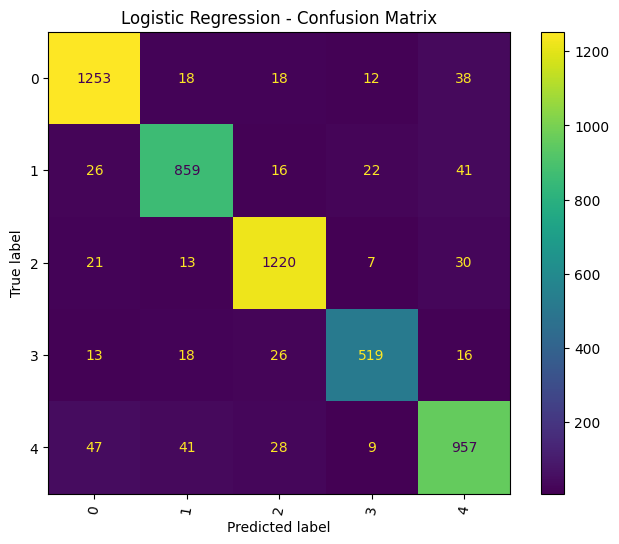

In [70]:
# Create LR model object
model_name = 'Logistic Regression'
model = LogisticRegression()

# Define Hyper Parameters
params = {'C': [0.01, 1, 10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# Create GridSearchCV object
grid_search_lr = GridSearchCV(model,
                          cv=folds,
                          param_grid=params,
                          scoring=None,
                          n_jobs=-1,
                          verbose=1)

# fit model
grid_search_lr.fit(X_train, y_train)

# Print best hyperparameters
print(f"{model_name} - Best Score: ", round(grid_search_lr.best_score_, 2))
print(f"{model_name} - Best Hyperparameters: ", grid_search_lr.best_params_)

# Instantiate metrics object
metric_lr=[]

# Compute & display the model metrics
compute_model_metrics(grid_search_lr,metric_lr)
display_model_metrics(model_name, grid_search_lr, metric_lr)

# Add the metrics to consolidated dataframe
df_metrics[model_name] = metric_lr[:8]

### 7.5 Build Decision Tree Model with Hyper Parameter Tunning

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Decision Tree - Best Score:  0.93
Decision Tree - Best Hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 30}
Decision Tree - ROC AUC Score Train: 0.97
Decision Tree - ROC AUC Score Test: 0.93
Decision Tree - Accuracy Score Train: 0.81
Decision Tree - Accuracy Score Test: 0.76
Decision Tree - Train Precision Score: 0.81; Recall Score: 0.81
Decision Tree - Test Precision Score: 0.76; Recall Score: 0.76

Decision Tree - Train Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      4017
           1       0.80      0.81      0.80      2890
           2       0.86      0.86      0.86      3873
           3       0.78      0.72      0.75      1778
           4       0.73      0.76      0.74      3246

    accuracy                           0.81     15804
   macro avg       0.80      0.80      0.80     15804
weighted avg       0.81      0.81      0.81     

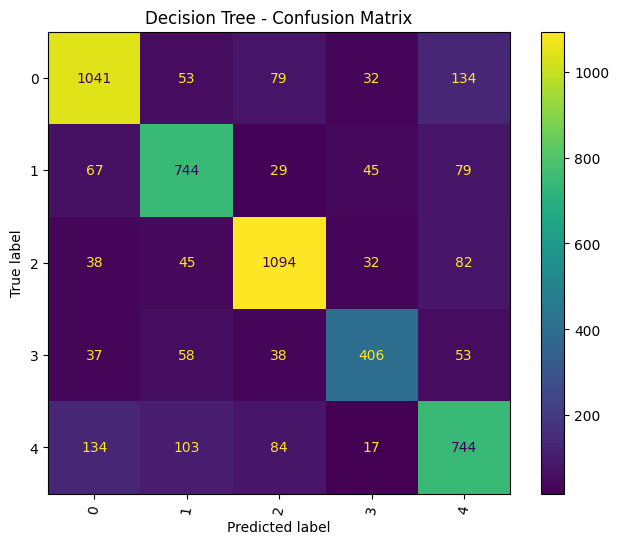

In [71]:
# Create Decision Tree model object
model_name = 'Decision Tree'
model = DecisionTreeClassifier(random_state=40)

# Define Hyper Parameters
params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
    }

# Create GridSearchCV object
grid_search_dt = GridSearchCV(model,
                          cv=folds,
                          param_grid=params,
                          scoring='roc_auc_ovr',
                          n_jobs=-1,
                          verbose=1)

# fit model
grid_search_dt.fit(X_train, y_train)

# Print best hyperparameters
print(f"{model_name} - Best Score: ", round(grid_search_dt.best_score_, 2))
print(f"{model_name} - Best Hyperparameters: ", grid_search_dt.best_params_)

# Instantiate metrics object
metric_dt=[]

# Compute & display the model metrics
compute_model_metrics(grid_search_dt,metric_dt)
display_model_metrics(model_name, grid_search_dt, metric_dt)

# Add the metrics to consolidated dataframe
df_metrics[model_name] = metric_dt[:8]

### 7.6 Build Random Forest Model with Hyper Parameter Tunning

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Random Forest - OOB SCORE : 0.8061250316375601
Random Forest - Best Score:  0.97
Random Forest - Best Hyperparameters:  {'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 700}
Random Forest - ROC AUC Score Train: 0.99
Random Forest - ROC AUC Score Test: 0.97
Random Forest - Accuracy Score Train: 0.92
Random Forest - Accuracy Score Test: 0.8
Random Forest - Train Precision Score: 0.92; Recall Score: 0.92
Random Forest - Test Precision Score: 0.8; Recall Score: 0.8

Random Forest - Train Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.93      4017
           1       0.95      0.89      0.92      2890
           2       0.91      0.96      0.94      3873
           3       0.94      0.81      0.87      1778
           4       0.94      0.89      0.91      3246

    accuracy                           0.92     15804
   macro avg       0.93      0.90    

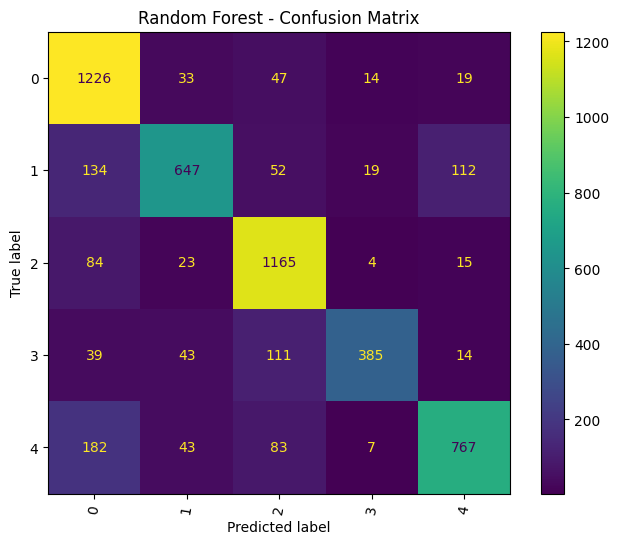

In [73]:
# Create Random Forest model object
model_name = 'Random Forest'
model = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# Define Hyper Parameters
params =  {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
          }

# Create GridSearchCV object
grid_search_rf = GridSearchCV(model,
                          cv=folds,
                          param_grid=params,
                          scoring='roc_auc_ovr',
                          n_jobs=-1,
                          verbose=1)

# fit model
grid_search_rf.fit(X_train, y_train)

# Print oob score
print(f"{model_name} - OOB SCORE :", grid_search_rf.best_estimator_.oob_score_)

# Print best hyperparameters
print(f"{model_name} - Best Score: ", round(grid_search_rf.best_score_, 2))
print(f"{model_name} - Best Hyperparameters: ", grid_search_rf.best_params_)

# Instantiate metrics object
metric_rf=[]

# Compute & display the model metrics
compute_model_metrics(grid_search_rf,metric_rf)
display_model_metrics(model_name, grid_search_rf, metric_rf)

# Add the metrics to consolidated dataframe
df_metrics[model_name] = metric_rf[:8]

### 7.7 Build Multinomial Naive Bayes Model with Hyper Parameter Tunning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Naive Bayes - Best Score:  0.75
Naive Bayes - Best Hyperparameters:  {'alpha': 0.1}
Naive Bayes - ROC AUC Score Train: 0.98
Naive Bayes - ROC AUC Score Test: 0.94
Naive Bayes - Accuracy Score Train: 0.84
Naive Bayes - Accuracy Score Test: 0.74
Naive Bayes - Train Precision Score: 0.85; Recall Score: 0.84
Naive Bayes - Test Precision Score: 0.75; Recall Score: 0.74

Naive Bayes - Train Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      4017
           1       0.86      0.75      0.80      2890
           2       0.85      0.91      0.88      3873
           3       0.88      0.73      0.80      1778
           4       0.86      0.81      0.84      3246

    accuracy                           0.84     15804
   macro avg       0.85      0.83      0.84     15804
weighted avg       0.85      0.84      0.84     15804


Naive Bayes - Test Classification Repo

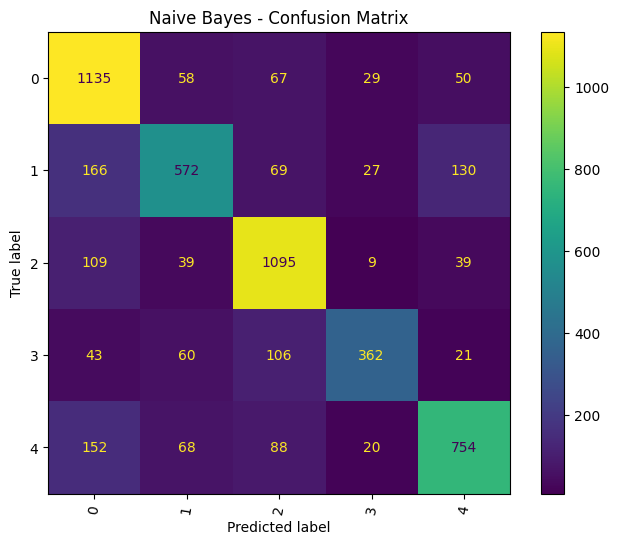

In [74]:
# Create MNB model object
model_name = 'Naive Bayes'
model = MultinomialNB()

# Define Hyper Parameters
params = {
'alpha': (1, 0.1, 0.01, 0.001)
}

# Create GridSearchCV object
grid_search_nb = GridSearchCV(model,
                          cv=folds,
                          param_grid=params,
                          scoring=None,
                          n_jobs=-1,
                          verbose=1)

# fit model
grid_search_nb.fit(X_train, y_train)

# Print best hyperparameters
print(f"{model_name} - Best Score: ", round(grid_search_nb.best_score_, 2))
print(f"{model_name} - Best Hyperparameters: ", grid_search_nb.best_params_)

# Instantiate metrics object
metric_mnb=[]

# Compute & display the model metrics
compute_model_metrics(grid_search_nb,metric_mnb)
display_model_metrics(model_name, grid_search_nb, metric_mnb)

# Add the metrics to consolidated dataframe
df_metrics[model_name] = metric_mnb[:8]

## 8. Best Model Selection

In [75]:
# Review the consolidated view of all model metrics
df_metrics

Logistic Regression  Decision Tree  Random Forest  \
Metric                                                                    
ROC AUC Score(Train)                 0.99           0.97           0.99   
ROC AUC Score(Test)                  0.99           0.93           0.97   
Accuracy(Train)                      0.92           0.81           0.92   
Accuracy(Test)                       0.91           0.76           0.80   
Precision(Train)                     0.92           0.81           0.92   
Precision(Test)                      0.91           0.76           0.80   
Recall(Train)                        0.92           0.81           0.92   
Recall(Test)                         0.91           0.76           0.80   

                      Naive Bayes  
Metric                             
ROC AUC Score(Train)         0.98  
ROC AUC Score(Test)          0.94  
Accuracy(Train)              0.84  
Accuracy(Test)               0.74  
Precision(Train)             0.85  
Precision(Test)              0.75  
Recall(Train)                0.84  
Recall(Test)                 0.74

**Selection Observations:** Based on the above evaluation matrix of all the 4 machine learning models, it is quite clear that the Logistic Regression model outperforms others in all metrics. While Random Forest shows a good ROC for both train & test, it lags behind in Accuracy and other scores.

Hence, **LR model with C=1** is being chosen as the selected model in this exercise.

## 9. Model Inference

In [76]:
# Test Commplaint Text
complaint = 'Chase Bank charged me $200 for annual fee for my Credit Card. I called up \
            bank\'s call center to waive-off the fee. After analysing my long term relationship \
            and good payment track record, the agent decided to waive-off the fees. It has been \
            2-months since that interaction, but the charge has not been waived. Please look into the matter.'

In [77]:
# Vectorize and tranform (tf-idf) the complaint text
complaint_vect = count_vect.transform([complaint])
complaint_tfidf = tfidf_transformer.transform(complaint_vect)

In [78]:
# Predict Topic using best model
predicted_topic = grid_search_lr.predict(complaint_tfidf)

In [79]:
Topic_numbers = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Mortgage/Loan':2,
    'Others':3,
    'Theft/Dispute Reporting':4
   }

In [80]:
# Map the prediction to Topic Name
predicted_topic_name = list(Topic_numbers.keys())[list(Topic_numbers.values()).index(predicted_topic[0])]
print("Predicted Topic for Test Complaint is:", predicted_topic_name)

Predicted Topic for Test Complaint is: Theft/Dispute Reporting


**Observations:** The above predictions is fine given that the complaint is actually regarding the dispute of Credit Card annual charges levied by the Bank.

## 10. Conclusion

The automatic ticket classification project successfully demonstrated the combination of `Topic Modeling` using `Non-Negative Matrix Factorization (NMF)` and supervised machine learning to address automatic customer complaint categorization. By clustering complaints into five topics, the NMF model provided a solid foundation for labeling the data, which was subsequently used to train and evaluate four machine learning models. Among these, Logistic Regression emerged as the best-performing model with an impressive test accuracy of 91% and balanced precision and recall scores across all categories.

The results highlight the effectiveness of this hybrid approach in automating ticket classification and improving operational efficiency. This exercise provides a scalable framework for similar classification problems, showcasing the potential of topic modeling and machine learning in real-world applications.